<!--NOTEBOOK_HEADER-->
*This notebook contains material from [Controlling Natural Watersheds](https://jckantor.github.io/Controlling-Natural-Watersheds);
content is available [on Github](https://github.com/jckantor/Controlling-Natural-Watersheds.git).*

<!--NAVIGATION-->
< [USGS Surface Water Daily Data](http://nbviewer.jupyter.org/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/A.07-USGS_Surface_Water_Daily_Data.ipynb) | [Contents](toc.ipynb) | [Rule Curves for Rainy and Namakan Lakes](http://nbviewer.jupyter.org/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/A.09-Rule_Curves_for_Rainy_and_Namakan_Lakes.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/A.08-Stage-Volume_Relationships.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/Controlling-Natural-Watersheds/master/notebooks/A.08-Stage-Volume_Relationships.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# Stage-Volume Relationships for Rainy and Namakan Lakes

Stage-Volume relationships expresses the relationship between lake surface elevation and the amount of water stored in the lake. For most flow and rule curve calculations, the most important feature of the stage-volume relationship is the change in lake volume associated with a change in lake volume.

This notebook displays stage-volume relationship data for Rainy Lake and Namakan Reservoir obtained from

>Thompson, A.F. (2013). Rainy and Namakan Hydrologic Response Model Documentation. Prepared for the Evaluation of the International Joint Commission 2000 Order for Rainy and Namakan Lakes and Rainy River.

The data is fitted to a polynomial function to create a dictionary of interpolation functions 

```
volume[key]()
```

and differentiated to create a dictionary of area functions 

```
area[key]()
```

These are pickled and stored in the data directory in files of the same name.

## Initialization

Initilization of the graphics system and computational modules used in this IPython notebook.

In [1]:
# Display graphics inline with the notebook
%matplotlib inline

# Standard Python modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import seaborn as sns
sns.set_context('talk')

# Modules to display images and data tables
from IPython.display import Image
from IPython.core.display import display

# Data directory
dir = '../data/'
img = '../images/'

## Stage-Volume Data - Thompson

The following data is extracted from Tables 1 and 2 of the Thompson report. Evidently these data were extracted from a 1932 stage/volume curve derived from earlier hydrographic measurements of the lakes.

The data is stored here in a dictionary constructed as key, dataframe pairs. (this is the old data.  We want to add a new data set, then compare new versus old estimates of area as function of lake level.).

In [2]:
data = {}

data['Rainy Lake'] = pd.DataFrame(
        [[335.0,  112.67],
        [336.0,  798.00],
        [336.5, 1176.42],
        [337.0, 1577.25],
        [337.5, 2002.06],
        [338.0, 2450.57],
        [339.0, 3416.85],
        [340.0, 4458.97]],
    columns = ['stage','volume'])

data['Namakan Reservoir'] = pd.DataFrame(
        [[337.0,  65.33],
        [338.0,  259.95],
        [338.5,  364.20],
        [339.0,  475.58],
        [339.5,  592.46],
        [340.0,  712.28],
        [340.5,  836.56],
        [341.0,  966.17],
        [341.5, 1099.79],
        [342.0, 1239.68],
        [343.0, 1540.75]],
    columns = ['stage','volume'])

Everything from this point on should be automatic and require no editing.

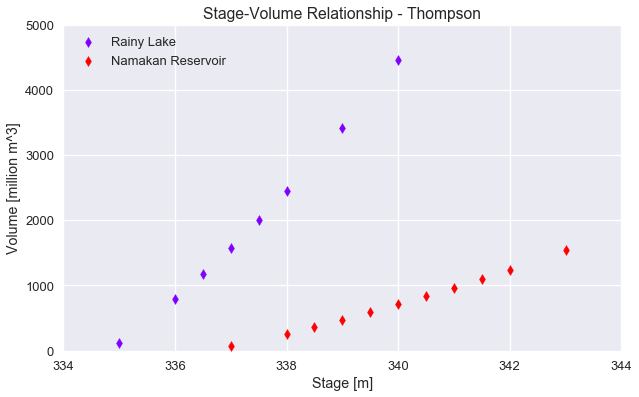

In [3]:
import matplotlib.cm as cm
colors = dict(zip(data.keys(),cm.rainbow(np.linspace(0, 1, len(data)))))

plt.figure(figsize=(10,6))
axes = plt.subplot()
for key in data.keys():
    data[key].plot(
        x = 'stage', 
        y = 'volume', 
        kind='scatter', 
        color = colors[key],
        s=50, marker='d', 
        ax = axes)

plt.xlabel('Stage [m]')
plt.ylabel('Volume [million m^3]')
plt.title('Stage-Volume Relationship - Thompson')
plt.legend(data.keys(),loc='upper left')
plt.xlim([334,344])
plt.ylim([0,5000]);

## Stage-Volume Data - Morin

In [4]:
data['Rainy Lake - Morin'] = pd.DataFrame(
        [[335.5,  7194.67197,  719.271],
         [336.0,  7570.67329,  770.153],
         [336.5,  7957.68641,  794.916],
         [337.0,  8358.73022,  833.198],
         [337.5,  8779.56914,  919.860],
         [338.0,  9244.10878,  966.400],
         [338.6,  9826.74905, 1011.093],
         [339.3, 10533.87720, 1048.357]],
    columns = ['stage','volume', 'area'])

dV = 7570.67329 - 798.0
data['Rainy Lake - Morin']['volume'] += -dV

data['Namakan Reservoir - Morin'] = pd.DataFrame(
        [[337.0,  65.33],
        [338.0,  259.95],
        [338.5,  364.20],
        [339.0,  475.58],
        [339.5,  592.46],
        [340.0,  712.28],
        [340.5,  836.56],
        [341.0,  966.17],
        [341.5, 1099.79],
        [342.0, 1239.68],
        [343.0, 1540.75]],
    columns = ['stage','volume'])

(334, 344)

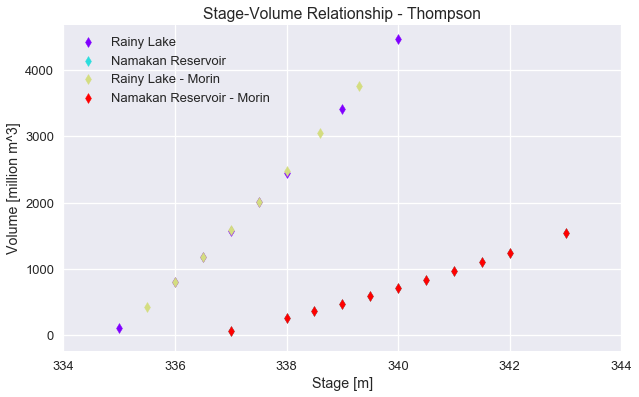

In [5]:
import matplotlib.cm as cm
colors = dict(zip(data.keys(),cm.rainbow(np.linspace(0, 1, len(data)))))

plt.figure(figsize=(10,6))
axes = plt.subplot()
for key in data.keys():
    data[key].plot(
        x = 'stage', 
        y = 'volume', 
        kind='scatter', 
        color = colors[key],
        s=50, marker='d', 
        ax = axes)

plt.xlabel('Stage [m]')
plt.ylabel('Volume [million m^3]')
plt.title('Stage-Volume Relationship - Thompson')
plt.legend(data.keys(),loc='upper left')
plt.xlim([334,344])
#plt.ylim([0,5000]);

## Fitting the Stage-Volume Relationship

Numpy provides functions to fit data to a polynomial of arbitrary degree, and to create a 1d interpolation based on the result.

In [6]:
volume = {}

for key in data.keys():
    volume[key] =  np.poly1d(np.polyfit(data[key]['stage'],data[key]['volume'],2))
    print("\n",key,"\n",volume[key])


 Rainy Lake 
        2
45.37 x - 2.975e+04 x + 4.876e+06

 Namakan Reservoir 
        2
10.14 x - 6653 x + 1.09e+06

 Rainy Lake - Morin 
        2
45.84 x - 3.006e+04 x + 4.924e+06

 Namakan Reservoir - Morin 
        2
10.14 x - 6653 x + 1.09e+06


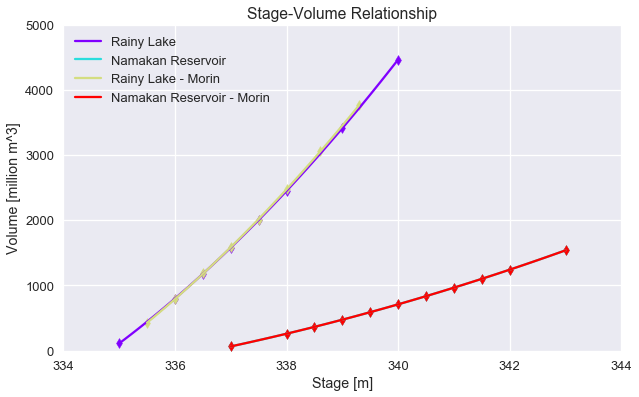

In [7]:
plt.figure(figsize=(10,6))

axes = plt.subplot()
for key in data.keys():
    data[key].plot(
        x = 'stage', 
        y = 'volume', 
        kind='scatter', 
        color = colors[key],
        s=50, marker='d', 
        ax = axes)
    h = np.linspace(data[key]['stage'].min(),data[key]['stage'].max())
    plt.plot(h,volume[key](h),color=colors[key])

plt.xlabel('Stage [m]')
plt.ylabel('Volume [million m^3]')
plt.title('Stage-Volume Relationship')
plt.legend(data.keys(),loc='upper left')
plt.xlim([334,344])
plt.ylim([0,5000]);

plt.savefig('../images/Stage-Volume.png')

## Stage-Area Relationships

The stage-area relationship expresses the dependence of lake area on lake elevation. 

In [8]:
area = {}
for key in data.keys():
    area[key] = volume[key].deriv()
    print("\n",key,"\n",area[key])


 Rainy Lake 
  
90.73 x - 2.975e+04

 Namakan Reservoir 
  
20.29 x - 6653

 Rainy Lake - Morin 
  
91.68 x - 3.006e+04

 Namakan Reservoir - Morin 
  
20.29 x - 6653


(334, 344)

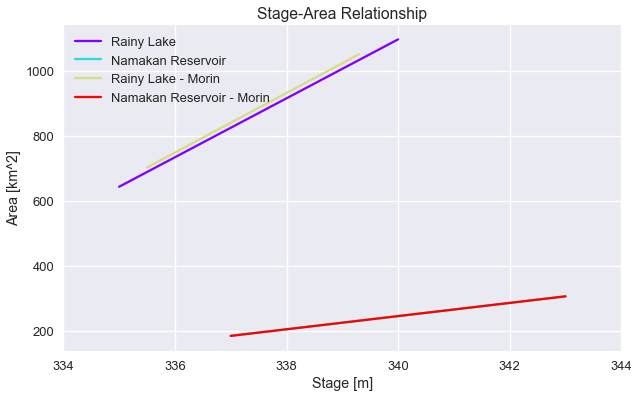

In [9]:
plt.figure(figsize=(10,6))

axes = plt.subplot()
for key in data.keys():
    h = np.linspace(data[key]['stage'].min(),data[key]['stage'].max())
    plt.plot(h,area[key](h),color=colors[key])

plt.xlabel('Stage [m]')
plt.ylabel('Area [km^2]')
plt.title('Stage-Area Relationship')
plt.legend(data.keys(),loc='upper left')
plt.xlim([334,344])

## Save Results

In [10]:
import pickle

with open(dir + 'area.pkl', 'wb') as handle:
  pickle.dump(area, handle)


In [11]:
with open(dir + 'area.pkl', 'rb') as handle:
  area = pickle.load(handle)

## Sample Use Cases

### Example: What is the Area of Rainy Lake at the Emergency High Water Level?

Under the emergency high water level for Rainy Lake under the 2000 Rule Curve is 337.5 meters.

In [12]:
file = open(dir + 'area.pkl', 'rb')  
area = pickle.load(file)
file.close()

display(area)

h_ehw = 337.90
a_ehw = area['Rainy Lake'](h_ehw)

h_nl = 340.95
a_nl = area['Namakan Reservoir'](h_nl)
print(a_nl)
print('Area of area at Emergency High Water =',  a_ehw, 'km^2')

{'Namakan Reservoir': poly1d([   20.28853147, -6652.59327511]),
 'Namakan Reservoir - Morin': poly1d([   20.28853147, -6652.59327511]),
 'Rainy Lake': poly1d([    90.73298003, -29751.96877493]),
 'Rainy Lake - Morin': poly1d([    91.68112663, -30055.98839021])}

264.781529137
Area of area at Emergency High Water = 906.705177419 km^2


#### Example: How much water is in Rainy Lake between the EHW and AGO levels?

In [13]:
file = open(dir + 'volume.pkl', 'rb')  
volume = pickle.load(file)
file.close()

display(volume)

h_ehw = 337.75
h_ago = 337.90

v_ehw = volume['Rainy Lake'](h_ehw)
v_ago = volume['Rainy Lake'](h_ago)

print('Volume of Rainy lake between EHW and EGO =', v_ago-v_ehw, 'million m^3')

UnicodeDecodeError: 'ascii' codec can't decode byte 0xe9 in position 4: ordinal not in range(128)

### Example: How long to drain Rainy Lake from AGO to EHW levels?

Assuming a net outflow of 1000 cubic meters/sec,

In [13]:
dv = (v_ago - v_ehw)*1.0e6
dt = dv/1000.0/86400.0

print('Time to empty =', dt, 'days')


NameError: name 'v_ago' is not defined

### Example: How much area is added to Rainy Lake between low and high water levels?

In [14]:
lrc = 336.80
urc = 337.75

a = 100*(area['Rainy Lake'](urc) - area['Rainy Lake'](lrc))/area['Rainy Lake'](lrc)

print("Area of Rainy lake increases by {:4.3f}% between low and high water of the 2000 rule curve order.".format(a))

Area of Rainy lake increases by 10.682% between low and high water of the 2000 rule curve order.


In [15]:
lrc = 336.80
urc = 338.745

a = 100*(area['Rainy Lake'](urc) - area['Rainy Lake'](lrc))/area['Rainy Lake'](lrc)

print("Area of Rainy lake increases by {:4.3f}% between low and high water of the 2000 rule curve order.".format(a))

Area of Rainy lake increases by 21.871% between low and high water of the 2000 rule curve order.


<!--NAVIGATION-->
< [USGS Surface Water Daily Data](http://nbviewer.jupyter.org/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/A.07-USGS_Surface_Water_Daily_Data.ipynb) | [Contents](toc.ipynb) | [Rule Curves for Rainy and Namakan Lakes](http://nbviewer.jupyter.org/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/A.09-Rule_Curves_for_Rainy_and_Namakan_Lakes.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/A.08-Stage-Volume_Relationships.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/Controlling-Natural-Watersheds/master/notebooks/A.08-Stage-Volume_Relationships.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>